# 1. Library Importation

In [1]:
# استيراد المكتبات
!pip install mediapipe

import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is

2025-04-24 13:54:52.735270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745502892.954323      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745502893.018913      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Skeletal Point Extraction Function

In [2]:
# إعداد MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# دالة لاستخراج الـ landmarks مع الـ scaling وتوسيط
def extract_and_scale_landmarks(image_path, img_size=400, padding=50):
    image = cv2.imread(image_path)
    if image is None or image.size == 0:
        print(f"Failed to load or empty image: {image_path}")
        return np.zeros(63)
    
    h, w, _ = image.shape
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if not results.multi_hand_landmarks:
        print(f"No hands detected in {image_path}")
        return np.zeros(63)
    
    landmarks = results.multi_hand_landmarks[0]
    handedness = "Right"
    if results.multi_handedness and len(results.multi_handedness) > 0:
        handedness = results.multi_handedness[0].classification[0].label
    
    # التأكد إن اليد يمين (قلب الصورة لو اليد شمال)
    if handedness == "Left":
        image = cv2.flip(image, 1)  # قلب أفقي
        for landmark in landmarks.landmark:
            landmark.x = 1 - landmark.x  # تعديل إحداثيات x بعد القلب
    
    # استخراج إحداثيات الـ landmarks بالبكسل
    points = [(int(l.x * w), int(l.y * h)) for l in landmarks.landmark]
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    
    hand_width, hand_height = x_max - x_min, y_max - y_min
    if hand_width < 10 or hand_height < 10:
        print(f"Hand too small in {image_path}: width={hand_width}, height={hand_height}")
        return np.zeros(63)
    
    x_min, y_min = max(0, x_min - padding), max(0, y_min - padding)
    x_max, y_max = min(w, x_max + padding), min(h, y_max + padding)
    
    hand_width, hand_height = x_max - x_min, y_max - y_min
    scale = (img_size - 2 * padding) / max(hand_width, hand_height)
    offset_x = (img_size - hand_width * scale) / 2
    offset_y = (img_size - hand_height * scale) / 2
    
    scaled_points = [
        (int((x - x_min) * scale + offset_x), int((y - y_min) * scale + offset_y))
        for x, y in points
    ]
    
    normalized_points = []
    for x, y in scaled_points:
        normalized_points.extend([x / img_size, y / img_size, 0.0])
    
    return np.array(normalized_points)

# 3. Data Upload and Processing

In [3]:
# مسار البيانات على Kaggle
data_dir = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset'  # استبدل بالمسار الصحيح

# إعداد البيانات
X = []  # النقاط
y = []  # التسميات
labels = sorted(os.listdir(data_dir))  # A, B, ..., Z, Blank

label_map = {label: idx for idx, label in enumerate(labels)}

# التأكد من عدد الفئات
print(f"Labels found: {labels}")
print(f"Number of classes: {len(labels)}")  # المفروض يكون 27 (A-Z + Blank)

# استخراج الـ landmarks من الصور مع الـ scaling وتوسيط
for label in tqdm(labels, desc="Processing labels"):
    label_dir = os.path.join(data_dir, label)
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        landmarks = extract_and_scale_landmarks(image_path, img_size=400, padding=50)
        X.append(landmarks)
        y.append(label_map[label])

# تحويل إلى مصفوفات NumPy
X = np.array(X)  # شكلها: (عدد الصور, 63)
y = np.array(y)  # شكلها: (عدد الصور,)
y = to_categorical(y, num_classes=len(labels))  # تحويل إلى One-Hot Encoding (27 فئة)

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745502904.267122      72 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745502904.297861      73 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Labels found: ['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah', 'Heh', 'Jeem', 'Kaf', 'Khah', 'Laa', 'Lam', 'Meem', 'Noon', 'Qaf', 'Reh', 'Sad', 'Seen', 'Sheen', 'Tah', 'Teh', 'Teh_Marbuta', 'Thal', 'Theh', 'Waw', 'Yeh', 'Zah', 'Zain']
Number of classes: 31


Processing labels:   0%|          | 0/31 [00:00<?, ?it/s]W0000 00:00:1745502904.531303      72 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_231.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_3.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_218.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_162.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_71.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_165.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_92.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_54.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ain/Ain_114.jpeg
No h

Processing labels:   3%|▎         | 1/31 [00:33<16:38, 33.29s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_45.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_136.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_266.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_16.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_9.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_63.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Al/Al_194.jpg


Processing labels:   6%|▋         | 2/31 [01:12<17:54, 37.04s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_107.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_31.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_198.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_124.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_93.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_234.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_69.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_192.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef

Processing labels:  10%|▉         | 3/31 [01:52<17:44, 38.03s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_279.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_45.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_287.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_215.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_137.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_63.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_87.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_233.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Beh/Beh_55.jpeg
No h

Processing labels:  13%|█▎        | 4/31 [02:38<18:38, 41.43s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_32.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_260.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_48.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_46.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_91.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_9.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_243.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_151.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dad/Dad_177.jpg
No han

Processing labels:  16%|█▌        | 5/31 [03:13<16:54, 39.02s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_84.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_116.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_232.JPEG
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_55.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_49.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_180.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_178.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_159.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Dal/Dal_121.jpg
No 

Processing labels:  19%|█▉        | 6/31 [03:48<15:38, 37.55s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_20.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_102.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_87.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_44.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_159.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_62.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_7.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_155.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Feh/Feh_111.jpg
No hand

Processing labels:  23%|██▎       | 7/31 [04:20<14:21, 35.90s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_102.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_196.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_112.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_66.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_53.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_111.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_123.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Ghain/Ghain_60.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB 

Processing labels:  26%|██▌       | 8/31 [04:51<13:08, 34.29s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_161.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_66.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_24.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_28.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_196.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_87.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_55.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_20.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Hah/Hah_100.jpeg
No ha

Processing labels:  29%|██▉       | 9/31 [05:20<11:56, 32.56s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_174.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_226.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_245.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_35.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_58.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_160.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_182.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_223.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Heh/Heh_193.jpg
N

Processing labels:  32%|███▏      | 10/31 [05:51<11:17, 32.27s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_27.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_59.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_86.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_172.JPG
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_125.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_200.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_73.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/Jeem_24.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Jeem/

Processing labels:  35%|███▌      | 11/31 [06:16<09:57, 29.88s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_243.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_159.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_90.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_123.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_126.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_51.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_43.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_180.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kaf/Kaf_36.jpg
No h

Processing labels:  39%|███▊      | 12/31 [06:50<09:50, 31.09s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_53.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_200.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_1.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_151.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_224.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_70.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_125.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_121.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Kh

Processing labels:  42%|████▏     | 13/31 [07:19<09:10, 30.60s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Khah/Khah_189.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_25.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_80.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_185.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_73.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_159.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_128.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_137.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Laa/Laa_8.jpg
No 

Processing labels:  45%|████▌     | 14/31 [07:53<08:57, 31.64s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_107.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_46.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_130.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_48.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_153.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_136.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_259.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Lam/Lam_166.jpg


Processing labels:  48%|████▊     | 15/31 [08:36<09:20, 35.03s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_55.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_94.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_191.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_0.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_193.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_153.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_151.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/Meem_59.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Meem/M

Processing labels:  52%|█████▏    | 16/31 [09:08<08:31, 34.11s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_147.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_140.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_103.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_35.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_121.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_88.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_23.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noon/Noon_142.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Noo

Processing labels:  55%|█████▍    | 17/31 [09:38<07:37, 32.69s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_142.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_37.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_18.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_199.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_201.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_90.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_91.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_25.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Qaf/Qaf_70.jpg
No hand

Processing labels:  58%|█████▊    | 18/31 [10:04<06:39, 30.71s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_42.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_209.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_210.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_56.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_59.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_144.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_116.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_133.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Reh/Reh_165.jpg
No 

Processing labels:  61%|██████▏   | 19/31 [10:30<05:53, 29.44s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_37.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_254.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_215.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_38.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_53.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_65.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_131.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_133.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sad/Sad_116.jpg


Processing labels:  65%|██████▍   | 20/31 [11:04<05:37, 30.72s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Seen/Seen_246.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Seen/Seen_136.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Seen/Seen_234.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Seen/Seen_53.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Seen/Seen_22.jpg


Processing labels:  68%|██████▊   | 21/31 [11:37<05:13, 31.32s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sheen/Sheen_125.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sheen/Sheen_196.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sheen/Sheen_41.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sheen/Sheen_66.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Sheen/Sheen_143.jpg


Processing labels:  71%|███████   | 22/31 [12:11<04:49, 32.18s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_41.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_101.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_206.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_138.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_106.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_47.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_202.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_2.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Tah/Tah_119.jpg
No ha

Processing labels:  74%|███████▍  | 23/31 [12:38<04:04, 30.60s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_217.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_251.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_116.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_234.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_8.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_229.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_57.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_65.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh/Teh_31.jpeg
No h

Processing labels:  77%|███████▋  | 24/31 [13:16<03:51, 33.06s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_74.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_59.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_215.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_201.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_126.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_91.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Marbuta_64.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Teh_Marbuta/Teh_Ma

Processing labels:  81%|████████  | 25/31 [13:51<03:20, 33.41s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_10.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_36.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_35.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_77.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_184.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_92.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_178.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/thal_54.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Thal/

Processing labels:  84%|████████▍ | 26/31 [14:18<02:38, 31.61s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_29.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_11.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_99.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_269.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_36.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_242.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_115.JPG
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_146.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Th

Processing labels:  87%|████████▋ | 27/31 [14:58<02:16, 34.14s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Theh/Theh_68.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_74.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_66.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_225.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_83.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_136.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_155.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_217.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Waw/Waw_122.jpg
No

Processing labels:  90%|█████████ | 28/31 [15:31<01:41, 33.82s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_235.jpg


Premature end of JPEG file


No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_61.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_55.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_98.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_97.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_249.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_119.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_50.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_92.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_210.jpg
No han

Processing labels:  94%|█████████▎| 29/31 [16:09<01:09, 34.87s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_33.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_117.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_180.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_175.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_69.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_63.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_101.JPEG
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_32.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zah/Zah_148.jpeg
No

Processing labels:  97%|█████████▋| 30/31 [16:38<00:33, 33.14s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_17.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_200.JPEG
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_42.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_108.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_51.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_71.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_0.jpeg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_62.jpg
No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Z

Processing labels: 100%|██████████| 31/31 [17:02<00:00, 32.98s/it]

No hands detected in /kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Zain/Zain_49.jpg
Training data shape: (5655, 63)
Validation data shape: (629, 63)
Test data shape: (1572, 63)


# 4. Build and assemble the model

In [4]:
# بناء النموذج
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(labels), activation='softmax')  # 27 فئة (A-Z + Blank)
])

# تجميع النموذج
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745503928.520263      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745503928.521031      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 31)                  │           1,023 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,551 (76.37 KB)

 Trainable params: 19,551 (76.37 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Model Training

In [5]:
# إعداد Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# تدريب النموذج
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping]
)

# تقييم النموذج على بيانات الاختبار
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/150


I0000 00:00:1745503931.561041      93 service.cc:148] XLA service 0x795c80009020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745503931.563097      93 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745503931.563114      93 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745503931.883407      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


122/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0455 - loss: 3.4188

I0000 00:00:1745503933.672511      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0545 - loss: 3.3933 - val_accuracy: 0.2321 - val_loss: 2.8285
Epoch 2/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2217 - loss: 2.6194 - val_accuracy: 0.5787 - val_loss: 1.5317
Epoch 3/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4524 - loss: 1.6907 - val_accuracy: 0.7027 - val_loss: 1.0682
Epoch 4/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5614 - loss: 1.3120 - val_accuracy: 0.7711 - val_loss: 0.8951
Epoch 5/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6185 - loss: 1.1500 - val_accuracy: 0.8140 - val_loss: 0.7955
Epoch 6/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6586 - loss: 1.0512 - val_accuracy: 0.7997 - val_loss: 0.7336
Epoch 7/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7001 - loss: 0.9636 - val_accuracy: 0.8331 - val_loss: 0.6584
Epoch 8/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7165 - loss: 0.8894 - val_accuracy: 0.814

# 6. Visualization of performance

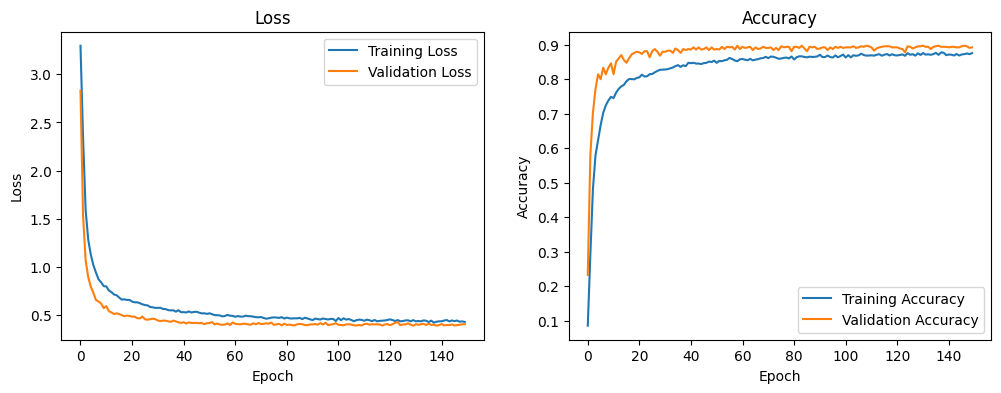

In [6]:
# رسم الخسارة والدقة
plt.figure(figsize=(12, 4))

# الخسارة
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# الدقة
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


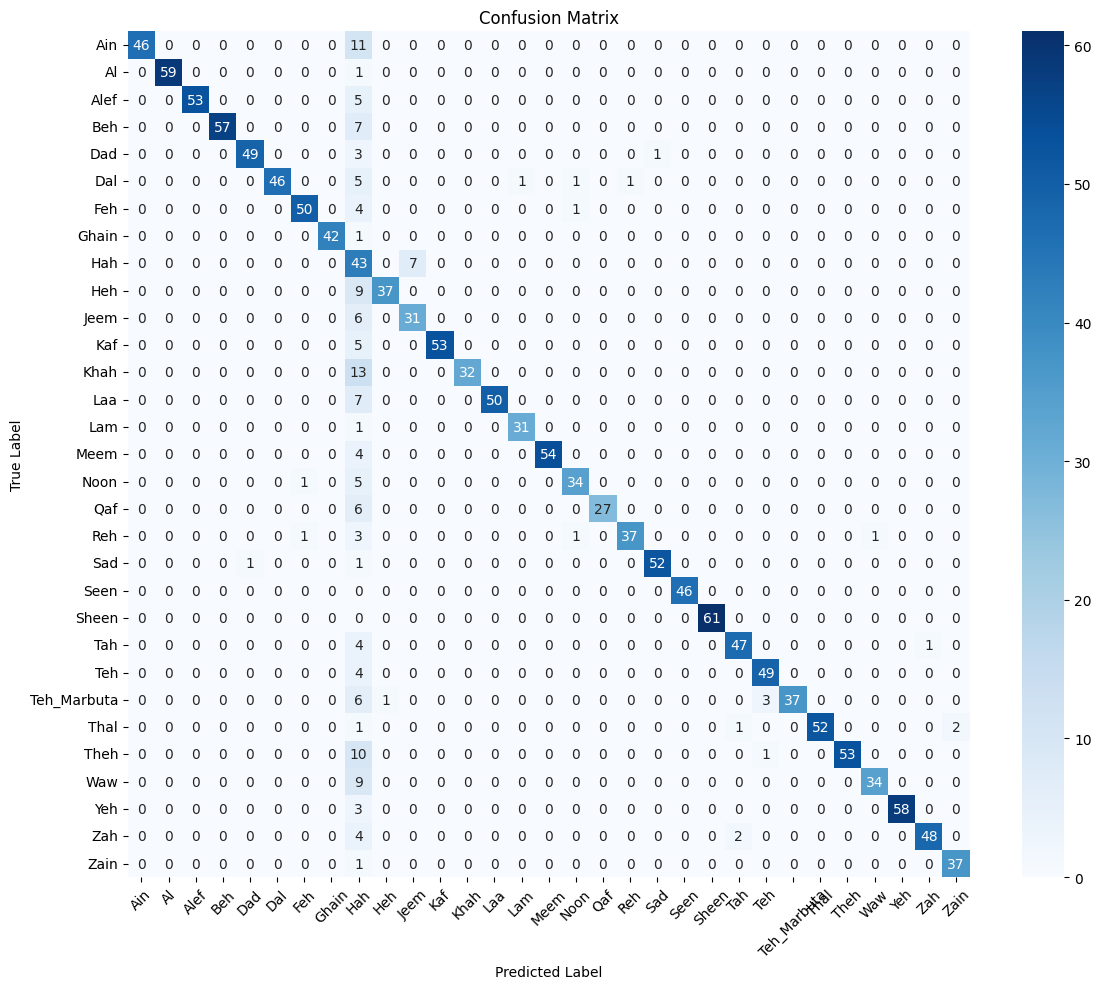


Classification Report:
              precision    recall  f1-score   support

         Ain       1.00      0.81      0.89        57
          Al       1.00      0.98      0.99        60
        Alef       1.00      0.91      0.95        58
         Beh       1.00      0.89      0.94        64
         Dad       0.98      0.92      0.95        53
         Dal       1.00      0.85      0.92        54
         Feh       0.96      0.91      0.93        55
       Ghain       1.00      0.98      0.99        43
         Hah       0.24      0.86      0.37        50
         Heh       0.97      0.80      0.88        46
        Jeem       0.82      0.84      0.83        37
         Kaf       1.00      0.91      0.95        58
        Khah       1.00      0.71      0.83        45
         Laa       1.00      0.88      0.93        57
         Lam       0.97      0.97      0.97        32
        Meem       1.00      0.93      0.96        58
        Noon       0.92      0.85      0.88        40
   

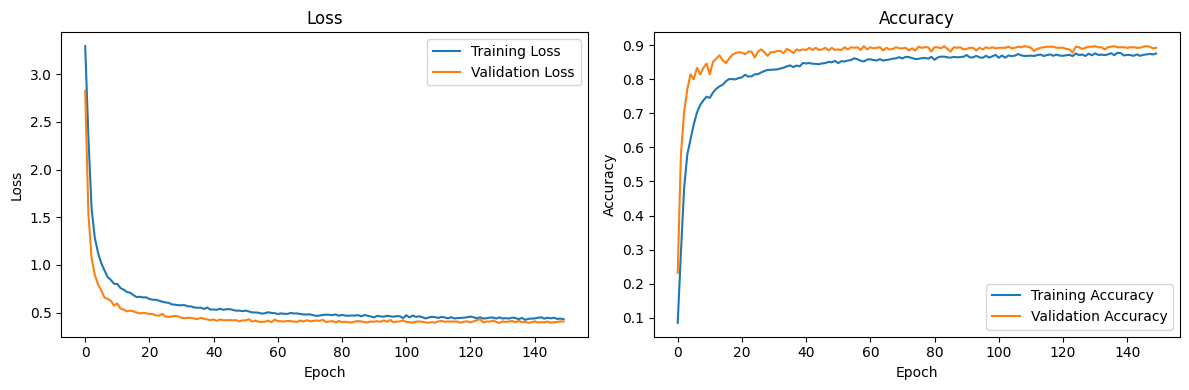

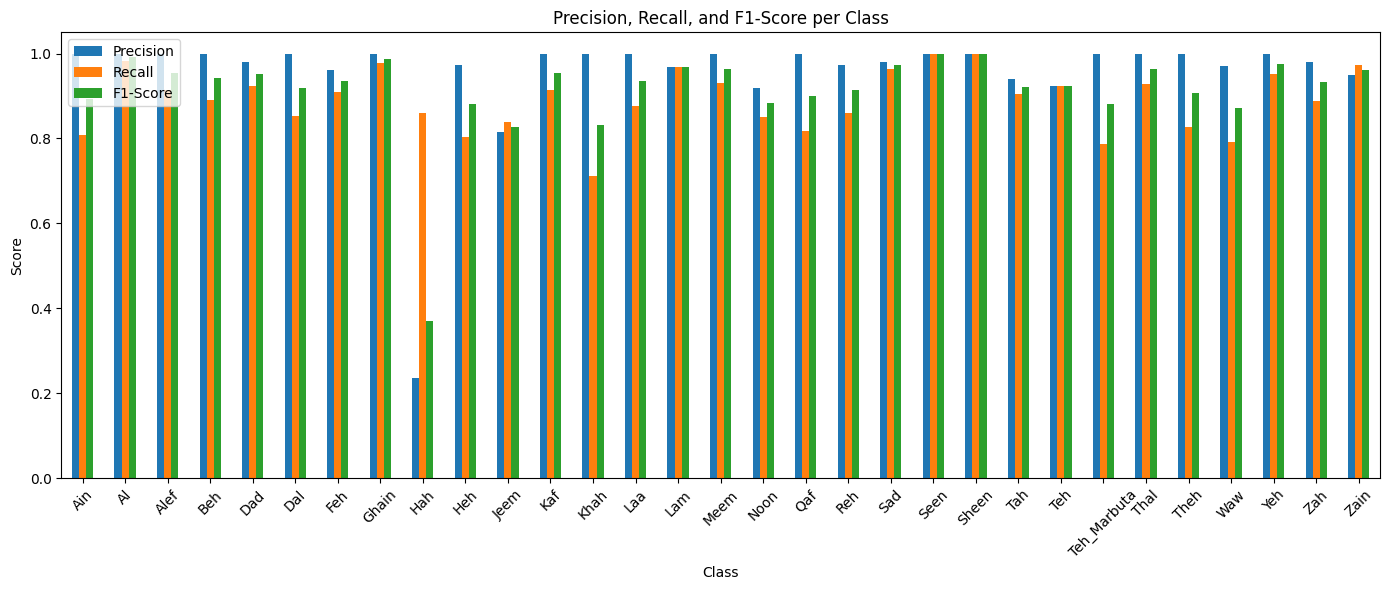

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# التنبؤ على بيانات الاختبار
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# رسم Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
class_report = classification_report(y_test_classes, y_pred_classes, target_names=labels)
print(class_report)

# 3. رسم الخسارة والدقة أثناء التدريب
plt.figure(figsize=(12, 4))

# الخسارة
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# الدقة
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 4. رسم Precision, Recall, F1-Score لكل فئة
from sklearn.metrics import precision_recall_fscore_support

# حساب Precision, Recall, F1-Score لكل فئة
precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average=None)

# إعداد البيانات للرسم
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=labels)

# رسم الـ Metrics
metrics_df.plot(kind='bar', figsize=(14, 6))
plt.title('Precision, Recall, and F1-Score per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 7. Save Model

In [8]:
model.save('/kaggle/working/arabic_sign_language_model.h5')
print("Model saved to /kaggle/working/arabic_sign_language_model.h5")

Model saved to /kaggle/working/arabic_sign_language_model.h5
